In [4]:
%cd drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
raw_df = pd.read_csv('AAPL.csv')
#raw_df.rename(columns={'Close': 'Closing Price', 'Adj Close': 'Adj Closing Price'}, inplace=True)
raw_df['Date'] = raw_df['Date'].apply(pd.to_datetime)
raw_df.set_index('Date',inplace=True)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2016-04-25 to 2021-04-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


## Create a Univariate dataset(Closing price and time)

In [7]:
X_uni = raw_df['Adj Close']
X_uni.head()

Date
2016-04-25    24.433960
2016-04-26    24.264212
2016-04-27    22.745811
2016-04-28    22.050558
2016-04-29    21.797100
Name: Adj Close, dtype: float64

Text(0, 0.5, 'Closing Prices')

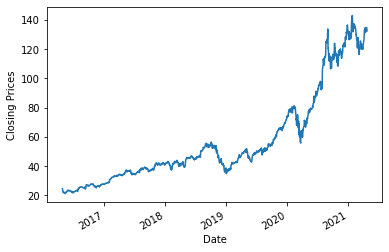

In [8]:
%matplotlib inline

X_uni.plot()
#X_uni.tail(60).plot()
plt.xlabel('Date')
plt.ylabel('Closing Prices')

## Split into training and testing

In [ ]:
forecast_length = 30
X_uni_train = X_uni[:-forecast_length]
X_uni_test = X_uni[-forecast_length:]

print(X_uni_train.shape)
print(X_uni_test.shape)

Date
2016-04-25    26.270000
2016-04-26    26.087500
2016-04-27    24.455000
2016-04-28    23.707500
2016-04-29    23.434999
Name: Close, dtype: float64
Date
2021-03-12    121.029999
2021-03-15    123.989998
2021-03-16    125.570000
2021-03-17    124.760002
2021-03-18    120.529999
Name: Close, dtype: float64


## Naive Forecast

In [ ]:
naive_forecast = X_uni_test.copy()

In [ ]:
listof = X_uni[1228:1258].values
to_rep = naive_forecast.values
naive_forecast.replace(to_rep,listof,inplace=True)

[121.959999 121.029999 123.989998 125.57     124.760002 120.529999
 119.989998 123.389999 122.540001 120.089996 120.589996 121.209999
 121.389999 119.900002 122.150002 123.       125.900002 126.209999
 127.900002 130.360001 133.       131.240005 134.429993 132.029999
 134.5      134.160004 134.839996 133.110001 133.5      131.940002]


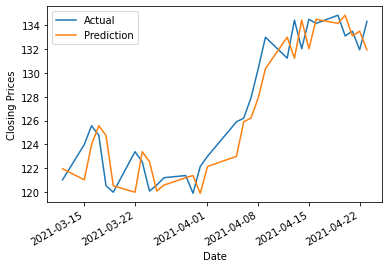

In [ ]:
%matplotlib inline

X_uni_test.plot(label='Actual')
naive_forecast.plot(label='Prediction')
#X_uni.tail(0).plot(label='Actual')
#naive_forecast.tail(10).plot(label='Prediction')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.legend()

In [ ]:
errors = naive_forecast - X_uni_test
#print(errors)
abs_errors = np.abs(errors)
mae = abs_errors.mean()
print(mae)

1.6846655999999973


## Linear Regression

In [10]:
import tensorflow as tf

keras = tf.keras

In [9]:
X_uni_train = X_uni[:894]
X_uni_test = X_uni[894:]

print(X_uni_train.shape)
print(X_uni_test.shape)

(894,)
(365,)


## Sliding Window

In [35]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

Build linear model and test the optimal learning rate

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)

window_size = 30
train_set = window_dataset(X_uni_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
34/34 [==============================] - 1s 2ms/step - loss: 40.3559 - mae: 40.8559
Epoch 2/100
34/34 [==============================] - 0s 3ms/step - loss: 19.8434 - mae: 20.3432
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 1.7986 - mae: 2.2473
Epoch 4/100
34/34 [==============================] - 0s 3ms/step - loss: 1.5027 - mae: 1.9324
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 1.2927 - mae: 1.7102
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 1.5176 - mae: 1.9376
Epoch 7/100
34/34 [==============================] - 0s 3ms/step - loss: 1.3647 - mae: 1.7851
Epoch 8/100
34/34 [==============================] - 0s 2ms/step - loss: 1.4197 - mae: 1.8457
Epoch 9/100
34/34 [==============================] - 0s 3ms/step - loss: 1.3940 - mae: 1.8134
Epoch 10/100
34/34 [==============================] - 0s 3ms/step - loss: 1.3837 - mae: 1.8031
Epoch 11/100
34/34 [==============================] - 0

(1e-06, 0.001, 0.0, 20.0)

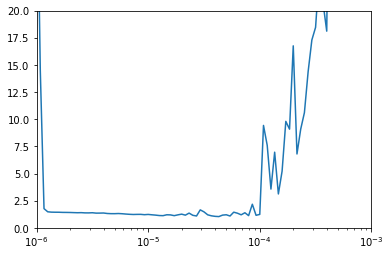

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

### 1e-5 looks like a stable learning rate

In [196]:
keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)

window_size = 30
train_set = window_dataset(X_uni_train, window_size)
test_set = window_dataset(X_uni_test, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
#optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=test_set,
          callbacks=[early_stopping])

Epoch 1/500
27/27 [==============================] - 1s 11ms/step - loss: 130.0114 - mae: 130.5114 - val_loss: 256.9962 - val_mae: 257.4962
Epoch 2/500
27/27 [==============================] - 0s 7ms/step - loss: 95.6051 - mae: 96.1051 - val_loss: 176.3782 - val_mae: 176.8782
Epoch 3/500
27/27 [==============================] - 0s 6ms/step - loss: 63.9854 - mae: 64.4854 - val_loss: 95.2560 - val_mae: 95.7560
Epoch 4/500
27/27 [==============================] - 0s 7ms/step - loss: 30.3412 - mae: 30.8412 - val_loss: 14.3766 - val_mae: 14.8758
Epoch 5/500
27/27 [==============================] - 0s 7ms/step - loss: 2.6771 - mae: 3.1503 - val_loss: 5.0515 - val_mae: 5.5415
Epoch 6/500
27/27 [==============================] - 0s 6ms/step - loss: 0.9443 - mae: 1.3622 - val_loss: 3.4262 - val_mae: 3.8954
Epoch 7/500
27/27 [==============================] - 0s 9ms/step - loss: 0.6345 - mae: 1.0186 - val_loss: 3.2784 - val_mae: 3.7441
Epoch 8/500
27/27 [==============================] - 0s 8ms/

## Graph and error

In [42]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [197]:
lin_forecast = model_forecast(model, X_uni[894 - window_size:-1], window_size)[:, 0]

<PrefetchDataset shapes: (None, None), types: tf.float64>


In [198]:
linear_forecast = X_uni_test.copy()
to_rep = linear_forecast.values
linear_forecast.replace(to_rep,lin_forecast.tolist(),inplace=True)

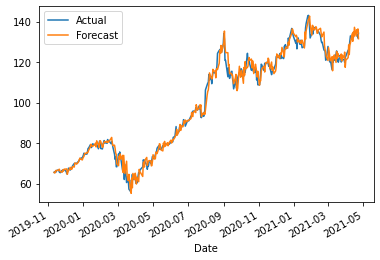

In [199]:
X_uni_test.plot(label='Actual')
linear_forecast.plot(label='Forecast')
plt.legend()

In [200]:
print(keras.metrics.mean_absolute_error(X_uni_test, linear_forecast).numpy())

2.1610250967138


## 2-layer Neural Network

In [201]:
keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)

window_size = 30
train_set = window_dataset(X_uni_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
27/27 [==============================] - 1s 3ms/step - loss: 24.1471 - mae: 24.6471
Epoch 2/100
27/27 [==============================] - 0s 2ms/step - loss: 23.4224 - mae: 23.9224
Epoch 3/100
27/27 [==============================] - 0s 3ms/step - loss: 23.0071 - mae: 23.5071
Epoch 4/100
27/27 [==============================] - 0s 3ms/step - loss: 22.3623 - mae: 22.8623
Epoch 5/100
27/27 [==============================] - 0s 2ms/step - loss: 21.4099 - mae: 21.9099
Epoch 6/100
27/27 [==============================] - 0s 2ms/step - loss: 20.6515 - mae: 21.1515
Epoch 7/100
27/27 [==============================] - 0s 2ms/step - loss: 19.9314 - mae: 20.4314
Epoch 8/100
27/27 [==============================] - 0s 3ms/step - loss: 18.7206 - mae: 19.2206
Epoch 9/100
27/27 [==============================] - 0s 2ms/step - loss: 17.4371 - mae: 17.9371
Epoch 10/100
27/27 [==============================] - 0s 3ms/step - loss: 16.1079 - mae: 16.6079
Epoch 11/100
27/27 [===================

(1e-07, 0.005, 0.0, 30.0)

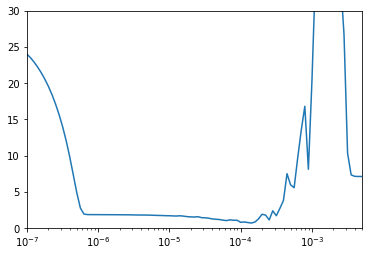

In [202]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [209]:
keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)

window_size = 30
train_set = window_dataset(X_uni_train, window_size)
test_set = window_dataset(X_uni_test, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

#optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=test_set,
          callbacks=[early_stopping])

Epoch 1/500
27/27 [==============================] - 1s 12ms/step - loss: 2.0029 - mae: 2.4561 - val_loss: 6.0566 - val_mae: 6.5452
Epoch 2/500
27/27 [==============================] - 0s 7ms/step - loss: 1.2089 - mae: 1.6242 - val_loss: 5.7695 - val_mae: 6.2538
Epoch 3/500
27/27 [==============================] - 0s 7ms/step - loss: 1.3020 - mae: 1.7335 - val_loss: 5.0022 - val_mae: 5.4792
Epoch 4/500
27/27 [==============================] - 0s 7ms/step - loss: 1.3531 - mae: 1.7922 - val_loss: 5.2886 - val_mae: 5.7751
Epoch 5/500
27/27 [==============================] - 0s 7ms/step - loss: 1.1447 - mae: 1.5703 - val_loss: 4.9549 - val_mae: 5.4389
Epoch 6/500
27/27 [==============================] - 0s 7ms/step - loss: 1.0943 - mae: 1.5147 - val_loss: 4.7800 - val_mae: 5.2549
Epoch 7/500
27/27 [==============================] - 0s 7ms/step - loss: 1.0576 - mae: 1.4742 - val_loss: 5.0633 - val_mae: 5.5500
Epoch 8/500
27/27 [==============================] - 0s 7ms/step - loss: 1.0572 - 

In [210]:
den_forecast = model_forecast(model, X_uni[894 - window_size:-1], window_size)[:, 0]

<PrefetchDataset shapes: (None, None), types: tf.float64>


In [211]:
dense_forecast = X_uni_test.copy()
to_rep = dense_forecast.values
dense_forecast.replace(to_rep,den_forecast.tolist(),inplace=True)

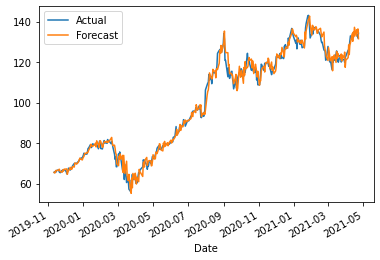

In [214]:
X_uni_test.plot(label='Actual')
linear_forecast.plot(label='Forecast')
plt.legend()

In [213]:
print(keras.metrics.mean_absolute_error(X_uni_test, dense_forecast).numpy())

2.396691379755725


## LSTM

In [12]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [26]:
keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)

window_size = 15
train_set = sequential_window_dataset(X_uni_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
59/59 [==============================] - 3s 7ms/step - loss: 123.7501 - mae: 124.2501
Epoch 2/100
59/59 [==============================] - 0s 7ms/step - loss: 104.5251 - mae: 105.0251
Epoch 3/100
59/59 [==============================] - 0s 7ms/step - loss: 83.4716 - mae: 83.9716
Epoch 4/100
59/59 [==============================] - 0s 6ms/step - loss: 61.6657 - mae: 62.1657
Epoch 5/100
59/59 [==============================] - 0s 7ms/step - loss: 38.7731 - mae: 39.2731
Epoch 6/100
59/59 [==============================] - 0s 7ms/step - loss: 14.5965 - mae: 15.0961
Epoch 7/100
59/59 [==============================] - 0s 6ms/step - loss: 8.0571 - mae: 8.5432
Epoch 8/100
59/59 [==============================] - 0s 6ms/step - loss: 7.1920 - mae: 7.6806
Epoch 9/100
59/59 [==============================] - 0s 8ms/step - loss: 6.9203 - mae: 7.4019
Epoch 10/100
59/59 [==============================] - 0s 7ms/step - loss: 7.1786 - mae: 7.6500
Epoch 11/100
59/59 [=======================

(1e-08, 0.0001, 0.0, 30.0)

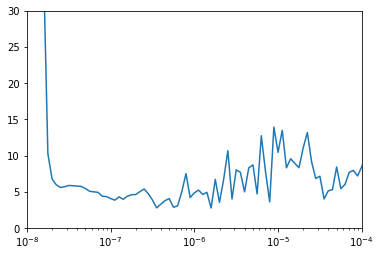

In [27]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [28]:
keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)

window_size = 30
train_set = sequential_window_dataset(X_uni_train, window_size)
test_set = sequential_window_dataset(X_uni_test, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=5e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=test_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
29/29 [==============================] - 3s 35ms/step - loss: 119.5298 - mae: 120.0298 - val_loss: 158.0203 - val_mae: 158.5203
Epoch 2/500
29/29 [==============================] - 0s 11ms/step - loss: 71.8859 - mae: 72.3859 - val_loss: 110.2140 - val_mae: 110.7139
Epoch 3/500
29/29 [==============================] - 0s 11ms/step - loss: 26.1437 - mae: 26.6436 - val_loss: 66.3032 - val_mae: 66.8032
Epoch 4/500
29/29 [==============================] - 0s 12ms/step - loss: 10.8125 - mae: 11.3096 - val_loss: 65.3225 - val_mae: 65.8225
Epoch 5/500
29/29 [==============================] - 0s 12ms/step - loss: 7.4342 - mae: 7.9259 - val_loss: 62.5868 - val_mae: 63.0868
Epoch 6/500
29/29 [==============================] - 0s 13ms/step - loss: 7.3229 - mae: 7.8150 - val_loss: 62.1216 - val_mae: 62.6216
Epoch 7/500
29/29 [==============================] - 0s 12ms/step - loss: 6.6306 - mae: 7.1210 - val_loss: 60.1012 - val_mae: 60.6012
Epoch 8/500
29/29 [=============================

In [29]:
model = keras.models.load_model("my_checkpoint.h5")

In [30]:
rnn_forecast = model.predict(X_uni[np.newaxis, :, np.newaxis])
#model_forecast(model, X_uni[894 - window_size:-1], window_size)[:, 0]
rnn_forecast = rnn_forecast[0, :, 0]
print(rnn_forecast.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


(1259,)


In [31]:
lstm_forecast = X_uni.copy()
to_rep = lstm_forecast.values
lstm_forecast.replace(to_rep,rnn_forecast.tolist(),inplace=True)

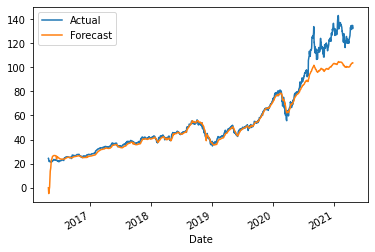

In [32]:
X_uni.plot(label='Actual')
lstm_forecast.plot(label='Forecast')
plt.legend()

In [33]:
print(keras.metrics.mean_absolute_error(X_uni, lstm_forecast).numpy())

4.72032148717609


## Preprocessing with 1-D CNN

In [36]:
keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)

window_size = 30
train_set = seq2seq_window_dataset(X_uni_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
7/7 [==============================] - 3s 14ms/step - loss: 72.2810 - mae: 72.7810
Epoch 2/100
7/7 [==============================] - 0s 11ms/step - loss: 71.4609 - mae: 71.9609
Epoch 3/100
7/7 [==============================] - 0s 8ms/step - loss: 71.7074 - mae: 72.2074
Epoch 4/100
7/7 [==============================] - 0s 10ms/step - loss: 70.7121 - mae: 71.2121
Epoch 5/100
7/7 [==============================] - 0s 9ms/step - loss: 69.5683 - mae: 70.0683
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 69.0092 - mae: 69.5092
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 67.9941 - mae: 68.4941
Epoch 8/100
7/7 [==============================] - 0s 10ms/step - loss: 66.5562 - mae: 67.0562
Epoch 9/100
7/7 [==============================] - 0s 9ms/step - loss: 65.0396 - mae: 65.5396
Epoch 10/100
7/7 [==============================] - 0s 10ms/step - loss: 63.5526 - mae: 64.0526
Epoch 11/100
7/7 [==============================] - 

(1e-08, 0.0001, 0.0, 30.0)

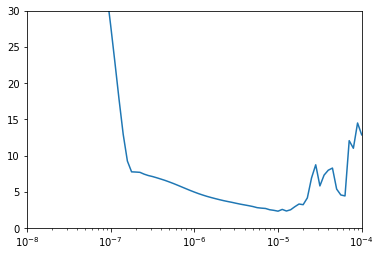

In [37]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [39]:
keras.backend.clear_session()
tf.random.set_seed(2)
np.random.seed(2)

window_size = 30
train_set = seq2seq_window_dataset(X_uni_train, window_size,
                                   batch_size=128)
test_set = seq2seq_window_dataset(X_uni_test, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=test_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
7/7 [==============================] - 4s 187ms/step - loss: 15.2119 - mae: 15.7033 - val_loss: 66.1011 - val_mae: 66.6010
Epoch 2/500
7/7 [==============================] - 0s 25ms/step - loss: 12.0292 - mae: 12.5195 - val_loss: 57.9693 - val_mae: 58.4693
Epoch 3/500
7/7 [==============================] - 0s 25ms/step - loss: 9.0728 - mae: 9.5618 - val_loss: 67.3714 - val_mae: 67.8714
Epoch 4/500
7/7 [==============================] - 0s 25ms/step - loss: 7.1789 - mae: 7.6632 - val_loss: 62.3802 - val_mae: 62.8802
Epoch 5/500
7/7 [==============================] - 0s 23ms/step - loss: 6.8161 - mae: 7.2930 - val_loss: 46.3477 - val_mae: 46.8474
Epoch 6/500
7/7 [==============================] - 0s 26ms/step - loss: 6.8808 - mae: 7.3674 - val_loss: 46.9820 - val_mae: 47.4821
Epoch 7/500
7/7 [==============================] - 0s 25ms/step - loss: 6.5128 - mae: 6.9986 - val_loss: 69.1355 - val_mae: 69.6355
Epoch 8/500
7/7 [==============================] - 0s 24ms/step - loss:

In [40]:
model = keras.models.load_model("my_checkpoint.h5")

In [62]:
lstm_cnn_forecast = model_forecast(model, X_uni[:,  np.newaxis], window_size)
lstm_cnn_forecast = lstm_cnn_forecast[:-1, -1, 0]
print(lstm_cnn_forecast.shape)

(1229,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


In [67]:
lcnn_forecast = X_uni[30:].copy()
to_rep = lcnn_forecast.values
lcnn_forecast.replace(to_rep,lstm_cnn_forecast.tolist(),inplace=True)

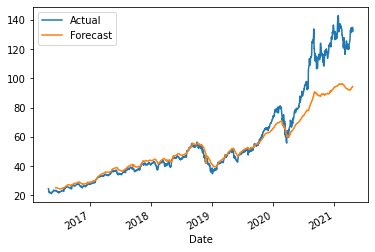

In [68]:
X_uni.plot(label='Actual')
lcnn_forecast.plot(label='Forecast')
plt.legend()

In [69]:
keras.metrics.mean_absolute_error(X_uni[30:], lcnn_forecast).numpy()

7.254210931973363